# Optimal control and reinforcement learning with the inverted pendulum

the goal of this exercise series is to gain practical experience implementing with value iteration, policy iteration and q-learning algorithms.

In [15]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle

First we define a few simple functions to display results

In [16]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation (with deltaT=0.1s)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [17]:
def plot_results(pend, value_function, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 20)

    plt.figure(figsize=[6,6])
    plt.imshow(value_function.reshape((pend.nq, pend.nv)), extent=[0., 2*np.pi, -pend.v_max, pend.v_max], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(policy.reshape((pend.nq, pend.nv)), extent=[0., 2*np.pi, -pend.v_max, pend.v_max], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Defining the pendulum

Here we define a class that provides functions to work with the inverted pendulum
This will be used by the value iteration algorithm and also to test the resulting policies

In [18]:
class DiscretePendulum:
    """
    This class describes a "discretized" inverted pendulum and provides some helper functions
    to use for value/policy iteration and q-learning with a table
    
    Rationale: as we will use the pendulum with algorithms using tables, we will handle a
    state (i.e. position and velocity of the pendulum) which will be discretized and for every
    state we will associate an index that enables to address the table (index is an integer from
    0 to number_of_q * number_of_v -1)
    """
    
    def __init__(self, nq=50, nv=50, nu=3, u_max=5., v_max=6.0):
        """
        constructor of the class, takes as input desired discretization number
        nq (for angle), nv (for angular velocity) and nu (for control) and the maximum control
        and angular velocity
        """
        #store discretization information
        self.nq=nq
        self.nv=nv
        self.nu = nu
        self.v_max = v_max
        
        # create lookup tables for discretized states
        self.u = np.linspace(-u_max, u_max, self.nu)
        self.q = np.linspace(0., 2*np.pi, self.nq, endpoint=False)
        self.v = np.linspace(-v_max, v_max, self.nv)
        
        #the total number of discretized states
        self.num_states = self.nq * self.nv
        
        #gravity constant
        self.g=9.81

        #discretization step
        self.delta_t = 0.1
        #integration step / smaller than discretization step to ensure stability of integration
        self.dt = 0.01
        self.integration_ratio = int(self.delta_t/self.dt)
        
        # we pre-compute every possible transition and store the index of the transition
        # in a 2D table (for element address the state and second the control)
        self.next_state_index = np.empty([self.num_states, self.nu], dtype=np.int32)
        for i in range(self.num_states):
            for k in range(self.nu):
                x_next = self.step(self.get_states(i), self.u[k])
                self.next_state_index[i,k] = self.get_index(x_next)
            
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds using
        an inner integration step of self.dt (to ensure stable integration)
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar number
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        for i in range(self.integration_ratio):
            x_next = (x[0] + self.dt * x[1])%(2*np.pi)
            v_next = np.clip(x[1] + self.dt * (u-self.g*np.sin(x[0])), -self.v_max, self.v_max)
            x = np.array([x_next,v_next])
        return x
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum of T seconds from initial state x0 using a discrete policy 
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        policy: a 1D array containing a discretized policy
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy[self.get_index(x[:,i])]
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

    
    def get_index(self, x):
        """
        given an arbitrary 2D state (x) of the pendulum it returns the associated index, 
        for example to use to address a table
        """
        ind_q = np.argmin((x[0]-self.q)**2)
        ind_v = np.argmin((x[1]-self.v)**2)
        return ind_q + ind_v*self.nq
    
    def get_states(self, index):
        """
        given an index, it returns the associated discretized state of the pendulum as a 2D vector
        """
        iv,ix = np.divmod(index, self.nq)
        return np.array([self.q[ix], self.v[iv]])                

## Cost function

This is the instantaneous cost $$g(x,v,u) = 1000(1-\cos(x-\pi))^2 + 100 v^2 + u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

In [31]:
def cost(x,u):
    """
    a cost function for the inverted pendulum
    """
    return 1000.*(1.-np.cos(x[0]-np.pi))**2 + 100.*x[1]**2 + 1.*u**2

## Value Iteration
The following class implements the value iteration algorithm as seen in the class. The algorithm is generic and could be used for any model. As a constructor, it gets a dynamic model (that needs to implement the same functions implemented by the pendulum class) and a cost function as define above.

In [32]:
class ValueIteration:
    """
    This class is used to implement value iteration and store the state of the value function and policy
    as we iterate
    """
    def __init__(self, model, cost, discount_factor=0.99):
        """
        receives as input a pendulum and cost function and potentially a discount factor
        """
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        """
        the main iteration of value iteration
        num_iter: maximum number of iterations to be performed. 
        
        If after an iteration the value function does not change (e.g. less thant 10e-5)
        the function returns and print success
        """
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_states(j)
                    u = self.model.u[l]
                    # the index for the next state
                    next_index = self.model.next_state_index[j,l]
                    #compute the cost
                    r[l] = self.cost(x, u) + self.gamma*self.value_function[next_index]
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.min(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = self.model.u[np.argmin(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [33]:
# we instantiate a pendulum with discretization 50x50 for angle q and velocity v and 3 actions
pendulum = DiscretePendulum(nq=50, nv=50, nu=3)

CONVERGED after iteration 892


<IPython.core.display.Javascript object>


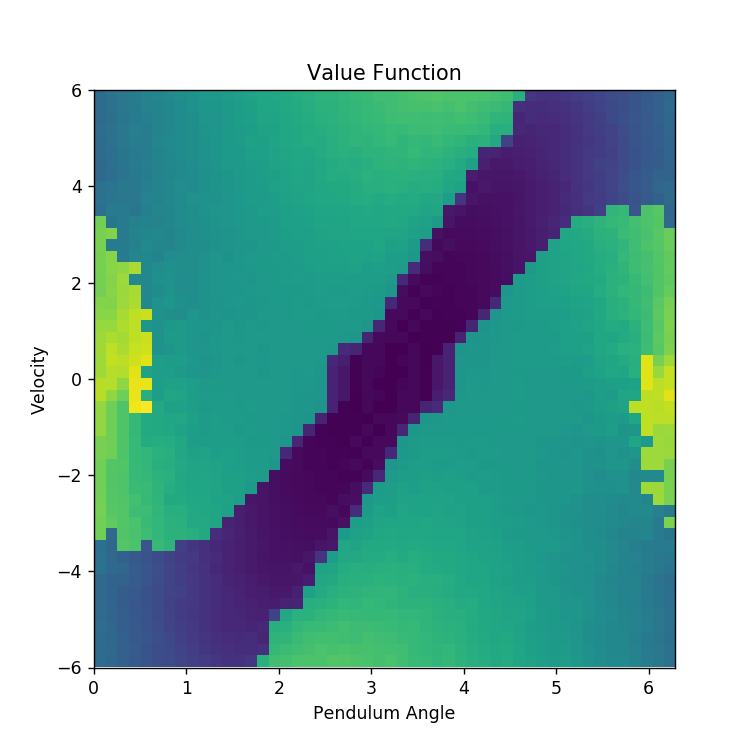

<IPython.core.display.Javascript object>


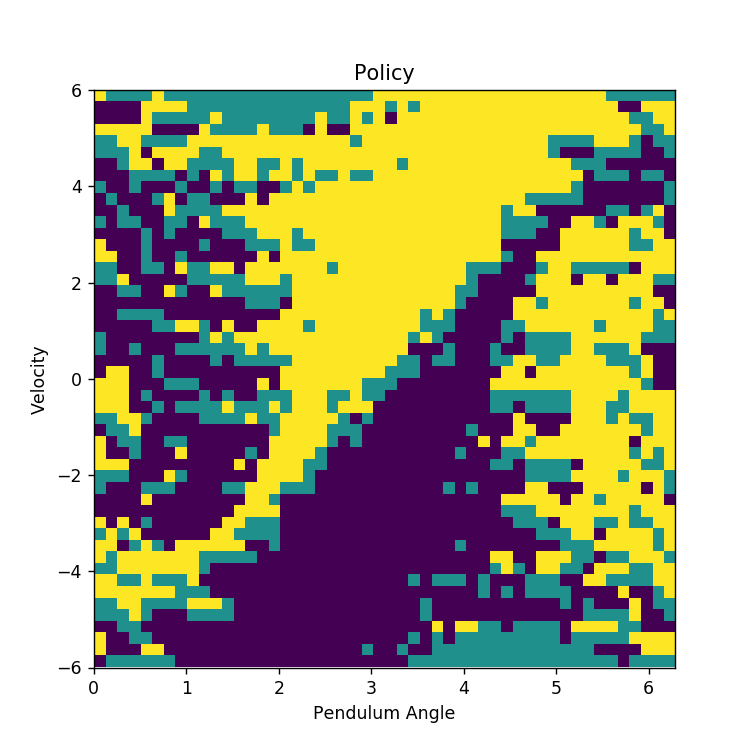

<IPython.core.display.Javascript object>


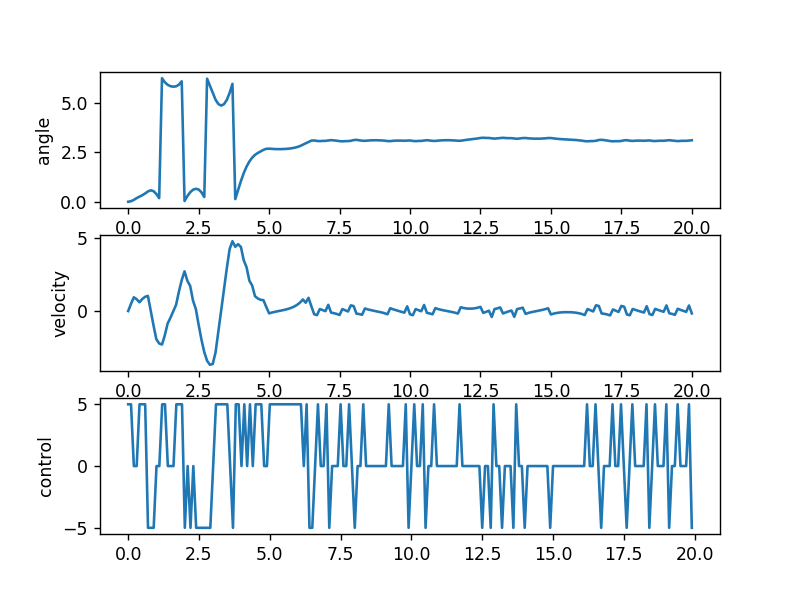

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADOK21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTAxIDdkMGZmMjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTggbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANE2WI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320iVM7NEnmHG6sJrpM/dh0nQ+5r39OQ6cHUFm0hB1kTY014bpkFYpfap7yuKrbFL3C
DF86Ek0m3piGtcybvONVtvleOBuQdzGdAa5YB52LAliqLd+bi6McnSKY2FoPfu5QadXS6EUfB0ep
YweeSRli/l0MDbC7pvc5D0pHCflfzYJd0GvBN+Tc9+CZCLt+T1EAFzZj+Wv7CTv80YchbrFtasJC
NYjeQyCadl0KgGz2/JEsFOkJUiPtq/wKfkNJeUSf9J37c2sBNTkM1gkUi/3xkDveK6vW5WnScaxf
EEWUnUfb7hzm/SxzoncYdAn5BZ9cwwymesZ+pg7wAFloui2wUH8seRsXC6KnsX7IVImY4+Oe/ano
SwLNniS2MzxbV1doQbay5LT+qzONsVBjTb4AivZVqlBz7UEVaqtzWm7XuiF9PPBefZ8oALnbWecA
AAMBLDBRyppjkCS+nOqJhuBcy6xUTlQjfGN0lmX1gZ4VQuWcWCnVM7lLYuK/XiiWJIeYSAF/K+Al
QZj6+JcX7eyUxRQ2+M3jcNu+XI9+1Cai1Sg2ZnqILS7wLes/5QCUhzldRLw6Mi6AD/02jJWYOCfA
v64sa38qd/OkSMhM82geKkah1t6+MlfPfQXqsKbxXmMBemR+shR+zWjzB7+tPJnCv62/jd1fmY1R
66MTT6IRi6qaKgQYoFVsCQe2vRfVdKSHBkI6XP+CIcijndhgeJMnryL6g8iPLW9lXzbq2Xf4iURR
Ws54Dv+ydX0vtnl2lJbKBotiDfFc/5//jho03ItE+ZEzzHCs2Bi64VFsUozdy0t8RF+/osb9jZtt
BadmzcfEaLYUfUcDJAvpd+WGMLgOHdLGfmQiUWHf2tR0tngmaDVYqsrK/gSqH+bkl/KFlPLLYWS1
C9hkmvXrclkTwbXG5Uevo8/Y8+nChep7YoSNKFgKMHJyd08/b+2rP28o4mSdZNZd1g7CthszVIeR
pTXeW4HMId13ROXS0ZMkGxVEluMWMsWM3QTV4HmonyuzVxQ8A1iBjOcSWwvQgO/dTMOl2CG0aXw8
DMKMVkbVoxLf5s2rnbnr7eT9UTRRv4vwIqISiUgDm+I2Yj9JmB/bHZnoHUaGoWlOt7jadAzhB/Aw
fJ7+R5v4ZwLNEdMxTDUda3WbVAmZQVgjD/wvHdY7sTDTeMt7LnYM6Vx/UDBCRNBrQamboh3Hv2gV
SEvG2HY13ElqN8UapKONvyPs6xp7SBQIH7I0DAjyOrfm2DxBo6Qk4etgBiwU202nns6pxJsNUeZt
tlANczuqTWbs70fmP+DEA1Sr/AbClbM439t/6VIeKDceG9+GHA2P2MwHkuoNzCSIp1PIQggSXGif
Y4XzTeNec+0QdrDeOQACYPrXQqt83WNoEEdKoWXNBMP5SGEO1KtqDPCzUIi68HSJyOmL0pEpBaN/
eJj1qnsIDqskqOQ7bjxLZzL7Mt6Inq2rnZgcBRNVc/C+YiVsSEAZLilyaEXXLIGMqDhzbl8t1PU3
v7fhYM5TiLdzB0JP+MVRvA3cISz63nv/V6TO0XOA0//c3uts3tOLVkbViTD16Y/68XTlg4g/3KRr
B77Lfh6PzkRRDZt+MIRTfLXkZNnd/RpmSzVqxkvRtTN6lmtu9zBURJOOZapZg7yGHie+xQPHv650
3crS0gumno3PCiJn1KeuEc1gXWE55wuh5Ny80PWW8RFnGk84RttCV/whou3zmssevBMZUf0sjK1O
aU2Pbww7c6qmw1tTGSQFFFckhPm9l7oI5HeY5K79q+5chqIy04iE5hJ9iQ5bofLucn7Lsq7GPZRG
SSXkSPtD5lX9s8B86ThzhuzW+vh37dABsAl5jsBAjw67QcSMNGaakxMFciyR9qYCCdCwuUoic0gj
1YqII4F08bLKzPRQnCyFv/9y6u9Wr1u7cLIRrWF4SOUW9OmhTjn4dtJnXb6XbtpouqGFm5KudU+a
G/qs12n62x57nGqRScWNlhCsNVcrW3PMipUk27a7pNUSt8FkyKwk/h5SR/HY6030xozcGqRhWaip
shYG3taGCZgVX1Yv2gbkOjgsKJ3whLY9LorUMgexw6GV8rsqKg95qpAAAGIPDT/SBR3BJCc716UO
LJNfukqkGNP4bHv/WDZwDPHwXfkyMBrbaOOp4X6GLWjPBfSpQ8t9T9peiXZNwVZ/r1bVQuFU8+Kn
jPEUp4t3sxYUI6VzV8BN6ItEuNAJ/f86iQ53844BdQsE6wbvrd+aCqjCqHJizNwNAiD0nC7RLudM
icc/8X2xz0FU18vMpnXr5sDoHYTc1pwcZFVOm2/5/MgE7v/J5VgVzjCY6QYvtLj5t3a7MfnnzRQh
XDYTxXIrqi8pK7tPNBq7rIYJmvjYd0oHDIO4yaHIZ9lelu9kOr+5PPckIEEg7+pjXmbHMQ8Rt6jx
K+/TNvJmChyEuHjDsigxJGbsRcsFsyYPk0Q4at/9eJabHcMj04PRPw7++M414v0Wdn8wTPqiYPmZ
erjxf/KrM09TkM1gkt9/8pxPyie2DvW4+IZSE7EIMcNdGX3YEPcj0VdyQRXJ2ttmDHs4RAzNPpf+
JpbbXJlN7BemD+eZxXYnz

In [34]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(pendulum, cost)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(2000)

# we plot the results
plot_results(pendulum, value_iteration.value_function, value_iteration.policy, animate=True)


## Exercise 1
Answer the question using the value iteration algorithm.
1. The algorithm converges in approximately 900 iterations - how many iterations does it take for the algorithm to find a policy that is capable of getting the pendulum upside down but which is not necessarily optimal?
2. Change the cost function to give more weight to the cost of control (weight 10, then 100 and then 1000). Analyze how the resulting optimal policy change when changing the control cost. Does the change in cost change the number of iteration necessary for convergence?
3. Do the same analysis when changing the weight of the velocity cost (keeping control cost to the original value and vary the velocity cost from 1 to 1000).
4. We now use a "sparse cost" of the form $$ g(x,v,u)  = \left\{ \begin{matrix} -1 & \textrm{if |x- $\pi$ |<0.2} \\ 1 & \textrm{otherwise} \end{matrix} \right. $$ where a cost occurs when the pendulum is not close to $\pi$. Analyze the resulting convergence of the algorithm and the solution obtained compared to the previous costs (include both policy and value functions plots).
5. The discretized pendulum contains 3 actions. What happens if 5 actions are used? Compare the solution with the solution found with 3 actions.

## Exercise 2
1. Implement the Policy Iteration algorithm 
(Hint: for each policy evaluation step, you may use the previous policy eavluation result as an initial start)
2. Compare the policies found using value and policy iteration - are they the same?
3. Which algorithm seem to be more efficient? Why?

In [30]:
class PolicyIteration:
    """
    Skeleton class to help implement policy iteration (you may use it or write your own solution)
    """
    def __init__(self, model, cost, discount_factor=0.99):
        """
        receives as input a pendulum and cost function and potentially a discount factor
        """
        # we create a table for the value and policy functions
        self.value_function = np.zeros([model.num_states])
        self.policy = np.zeros([model.num_states])
        # we also store the index associated to the policy
        self.policy_index = np.zeros([model.num_states], dtype=np.int32)
        
        self.model = model
        self.cost = cost
        self.gamma = discount_factor
            
    def iterate(self, num_iter=1):
        """
        the main iteration of policy iteration
        num_iter: maximum number of iterations to be performed. 
        
        If after an iteration the policy does not change (e.g. less thant 10e-5) 
        the function should return and print success
        """
        for i in range(num_iter):
            #policy evaluation
            self.policy_evaluation()
            #policy update
            if not self.policy_update():
                print('CONVERGED after iteration ' + str(i))
                break
            
    def policy_update(self):
        """
        TO BE COMPLETED
        Policy update function 
        it should return True if the policy was changed and False otherwise
        """
        
        
        return True
            
    def policy_evaluation(self, num_iter=10000):
        """
        TO BE COMPLETED
        Policy evaluation function 
        """
        p_new = self.policy.copy()
        j_new = self.value_function.copy()
        for j in range(self.model.num_states):
            for l in range(self.model.nu):
                x = self.model.get_tates(j)
                u = self.model.nu(l)
                pi = self.policy(j)
                next_index = self.model.next_state_index[j,l]
                j_new[j] = self.cost(x, pi) + self.gamma*self.value_function[next_index]

The following two exercises are Bonus. Answering these questions will give additional points towards the final grade but it is not necessary to answer them to get the maximum grade.

## Exercise 3 [Bonus]
1. Implement Q-learning with a table (use episodes of at least 10 seconds and an epsilon greedy policy with $\epsilon=0.1$).
2. How many iterations does it take for the algorithm to learn how to invert the pendulum?
3. How can you compute the optimal policy from the Q function? And the optimal value function?
4. Plot the learned policy and associated value function and also show these functions at different stages of learning.
5. How is learning affected when changing $\epsilon$ and the learning rate?

In [ ]:
class QLearningTable:
    """
    Skeleton class to help implement Q learning with a table (you may use it or write your own solution)
    """
    def __init__(self, model, cost, discount_factor=0.99, learning_rate=0.1, epsilon_greedy=0.1):
        # we create tables to store value and policy functions
        self.value_function = np.zeros([model.num_states])
        self.policy = np.zeros([model.num_states])
        
        # we create the Q table
        self.q_function = np.zeros([model.num_states, model.nu])
        
        self.model = model
        self.cost = cost
        
        # other parameters
        self.epsilon = epsilon_greedy
        self.gamma = discount_factor
        self.alpha = learning_rate
            
    def iterate(self, num_iter=1):
        """
        TO BE COMPLETED
        """
        
